/var/folders/t3/xhtsf2011qndtzgvjdgdnylw0000gn/T/ipykernel_48796/3535233844.py:26: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}\usepackage{bm}"]


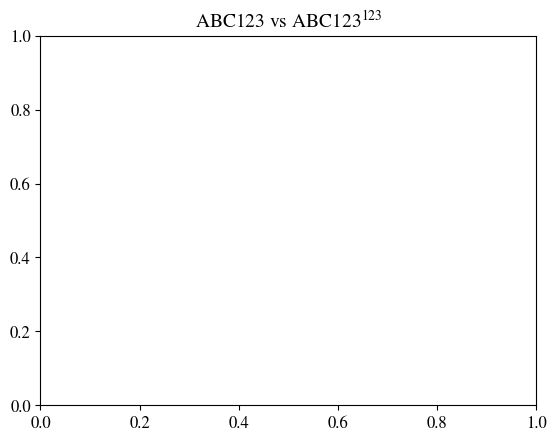

In [23]:
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.font_manager
from matplotlib.lines import Line2D
from matplotlib import rc
import matplotlib
from math import sqrt

import json
%matplotlib inline

rc('font', family='serif', style='normal', variant='normal', weight='normal', stretch='normal', size=8)
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.style.use('default')
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}\usepackage{bm}"]


In [24]:
exp_dir = "../experiments/experiment_v1/"
max_hv_dir = "./max_hvs/"

In [25]:
from matplotlib.ticker import FormatStrFormatter

plot_args = {
    # "sobol": {"label": "Sobol", "color": "tab:pink"},
    # "nparego": {"label": "qNParEGO", "color": "tab:brown", "ls": "--"},
    # "nehvi_rff": {"label": "NEHVI-RFF", "color": "tab:gray", "ls": "-."},
    # "nehvi": {"label": "qNEHVI", "color": "tab:gray"},
    # "expectation_nparego": {"label": "Exp-qNParEGO", "color": "tab:olive", "ls": "--"},
    # "expectation_nehvi_rff": {"label": "Expectation NEHVI-RFF", "color": "tab:cyan", "ls": "-."},
    "ref_mvar_nehvi_rff": {"label": "MVaR NEHVI-RFF", "color": "tab:pink", "ls": "-."},
    # "ref_mvar_nehvi": {"label": "MVaR NEHVI", "color": "tab:cyan", "ls": "-"},
    "ref_ch-var-nei": {"label": "MARS-NEI", "color": "tab:red", "ls": "--"},
    # "ch-var-ucb": {"label": "MARS-UCB", "color": "tab:cyan", "ls": ":"},
    # "ref_ch-var-ts": {"label": "MARS-TS", "color": "tab:brown", "ls": (0, (3, 5, 1, 5, 1, 5))},
}
labels = list(plot_args.keys())
N_REPS = 20
verbose = False
shade_alpha = 0.1
plot_regret = True
plot_log = True
default_figsize = (5, 4)
legend_cols = 1


def plot(problem, basename: str, max_hv_name: str = None, title=None, marker=None, fig=None, ax=None):
    if plot_regret:
        if max_hv_name is None:
            max_hv_name = problem
        max_hv = torch.load(
            os.path.join(max_hv_dir, f"{max_hv_name}.pt")
        )["max_hv"]
    min_iter = 200 if problem == "penicillin" else 100
    final_regrets = {}
    final_sem = {}
    for q in [1, 2, 4, 8]:
        agg_results = {}
        for label in labels:
            for seed in range(N_REPS):
                p_name = f"{basename}{q}" if q != 1 else problem
                path = os.path.join(exp_dir, p_name, label, f"{str(seed).zfill(4)}_{label}.pt")
                try:
                    res = torch.load(path, map_location="cpu")
                except (FileNotFoundError, EOFError):
                    if verbose:
                        print(f"No file found, skipping: {os.path.basename(path)}!")
                    continue
                if label not in agg_results:
                    agg_results[label] = {k: (v.unsqueeze(0) if torch.is_tensor(v) else v) for k,v in res.items()}
                else:
                    label_res = agg_results[label]
                    for k,v in res.items():
                        if torch.is_tensor(v):
                            if v.shape[0] != label_res[k].shape[1]:
                                if v.shape[0] < min_iter:
                                    if verbose:
                                        print(f"Insufficient iterations, skipping: {os.path.basename(path)}!")
                                    break
                                # partial result
                                max_iter = min(label_res[k].shape[1], v.shape[0])
                                label_res[k] = label_res[k][:, :max_iter]
                                v = v[:max_iter]
                            label_res[k] = torch.cat([label_res[k], v.unsqueeze(0)], dim=0)
        final_regrets[q] = {}
        final_sem[q] = {}
        for label in labels:
            try:
                res = agg_results[label]
            except KeyError:
                continue
            hvs = res["all_mvar_hvs"]
            hv_mean = hvs.mean(dim=0)
            hv_sem = hvs.std(dim=0)/sqrt(hvs.shape[0])
            if plot_regret:
                hv_mean = max_hv - hv_mean
            final_regrets[q][label] = hv_mean[-1]
            final_sem[q][label] = hv_sem[-1]
            mean_time = res['wall_time'].mean(dim=0)[-1]
            sem_time = res['wall_time'].std(dim=0)[-1] / sqrt(hvs.shape[0]) * 2
            print(f"q: {q}, Label: {label}, num replications: {hvs.shape[0]}, time: {mean_time}, +- {sem_time}")

    using_existing_fig = fig is not None
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, figsize=default_figsize)
    for label in labels:
        xs = []
        ys = []
        sems = []
        for q in [1, 2, 4, 8]:
            try:
                ys.append(final_regrets[q][label].item())
                sems.append(2 * final_sem[q][label].item())
                xs.append(q)
            except KeyError:
                continue
        print(xs, ys, sems)
        ax.errorbar(xs, ys, yerr=sems, label=plot_args[label]["label"], capsize=5)
    if title:
        ax.set_title(title)
    else:
        ax.set_title(problem)
    # if plot_log:
    #     ax.set_yscale("log")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.legend(loc=1, ncol=legend_cols)
    fig.tight_layout()
    ax.set_ylabel("Final MVAR HV Regret")
    ax.set_xlabel("Batch Size")
    if title:
        plt.savefig(f"plots/{title}.pdf", dpi=300, bbox_inches='tight')


q: 1, Label: ref_mvar_nehvi_rff, num replications: 20, time: 255.56074304580687, +- 22.158014210634455
q: 1, Label: ref_ch-var-nei, num replications: 20, time: 1042.893480157852, +- 210.76517870003465
q: 2, Label: ref_mvar_nehvi_rff, num replications: 20, time: 400.3531716108322, +- 66.0499256691005
q: 2, Label: ref_ch-var-nei, num replications: 19, time: 1444.4746614004437, +- 212.99270281911052
q: 4, Label: ref_mvar_nehvi_rff, num replications: 20, time: 575.5115699529648, +- 51.734023642054666
q: 4, Label: ref_ch-var-nei, num replications: 20, time: 1924.556299328804, +- 369.0947283157054
q: 8, Label: ref_ch-var-nei, num replications: 20, time: 2021.2380865573882, +- 505.17089792514287
[1, 2, 4] [0.8715333092847715, 1.0333859765504911, 1.2136283039956481] [0.06971803155663131, 0.04690198840848011, 0.0693035358167292]
[1, 2, 4, 8] [0.8624758622885196, 0.9225439669300357, 0.9213832415725705, 0.9261248286956345] [0.04975671057944011, 0.043030106919265815, 0.07440940600990047, 0.0758048

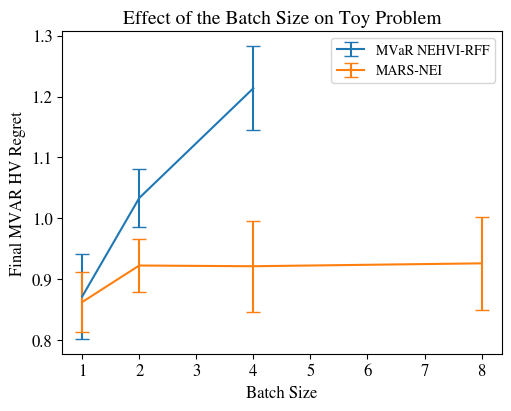

In [26]:
plot("1d_toy", "1d_toy_q", title="Effect of the Batch Size on Toy Problem")

q: 1, Label: ref_mvar_nehvi_rff, num replications: 20, time: 579.7082931995392, +- 47.412281831073805
q: 1, Label: ref_ch-var-nei, num replications: 20, time: 719.6620549678803, +- 45.999912357933695
q: 2, Label: ref_mvar_nehvi_rff, num replications: 20, time: 23778.15379744768, +- 2988.889586145392
q: 2, Label: ref_ch-var-nei, num replications: 20, time: 772.5843499660492, +- 48.838763748514125
q: 4, Label: ref_ch-var-nei, num replications: 20, time: 772.5957899212838, +- 57.51970550750222
q: 8, Label: ref_ch-var-nei, num replications: 20, time: 881.56173453331, +- 67.68497426998879
[1, 2] [4.355800169839313, 6.195272271460908] [0.12510274310065644, 0.35503180381310867]
[1, 2, 4, 8] [5.4321654358655, 5.1960497298825885, 5.575122734049728, 5.590016244579829] [0.2737925927603257, 0.2059288080997936, 0.38439944899961315, 0.41029947691179147]


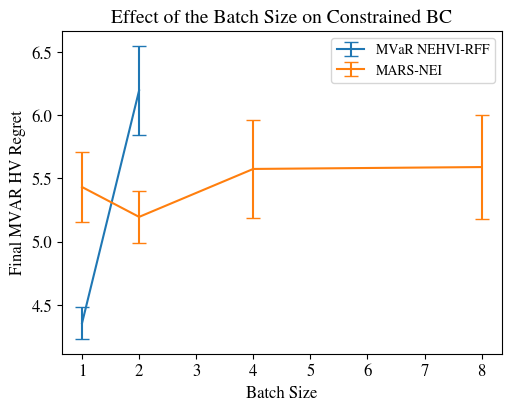

In [27]:
plot("bc_v2", "bc_q", title="Effect of the Batch Size on Constrained BC")